## Import dependencies

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, plot
import plotly.express as px
from scipy.stats import norm, kurtosis
from scipy.signal import butter, lfilter, freqz
from scipy import signal
from sklearn.model_selection import train_test_split
from collections import Counter

import glob
import os

# plt.rcParams["figure.figsize"] = 16,10


from processing_funcs import *

## Read data

In [93]:
df = read_all(1/50)

### Checking the data

In [94]:
df.head()

time  measurementID        lat        lon      height   velocity  \
88  1.76              0  47.695267  17.724532  120.897892  10.737622   
89  1.78              0  47.695267  17.724532  120.897892  10.737622   
90  1.80              0  47.695267  17.724532  120.897892  10.737622   
91  1.82              0  47.695267  17.724532  120.897892  10.737622   
92  1.84              0  47.695267  17.724532  120.897892  10.737622   

    direction  h_accuracy  v_accuracy  id_gps  x_lin_acc  y_lin_acc  \
88       -1.0        48.0        48.0       2  -0.083352   0.075551   
89       -1.0        48.0        48.0       2  -0.104502  -0.012796   
90       -1.0        48.0        48.0       2  -0.153944   0.022597   
91       -1.0        48.0        48.0       2   0.010478  -0.010180   
92       -1.0        48.0        48.0       2   0.049073   0.005206   

    z_lin_acc    x_gyro    y_gyro    z_gyro     x_acc     y_acc     z_acc  \
88   0.103305 -0.005730 -0.006268  0.012660 -0.350945  1.542168  9.808054   
89   0.027300 -0.002752 -0.006228  0.012159 -0.358804  1.459390  9.713825   
90   0.076752 -0.003280  0.004944  0.009772 -0.409997  1.517694  9.802965   
91   0.161632 -0.005562  0.006767  0.011544 -0.263901  1.500555  9.809925   
92   0.011759 -0.001736  0.003140  0.011980 -0.255818  1.521137  9.740769   

    label  
88      0  
89      0  
90      0  
91      0  
92      0

In [95]:
fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="lon",
                        zoom = 12, 
                        height=500, 
                        color = "label", 
                        color_continuous_scale=["green","blue","red"])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.showscale = False
fig

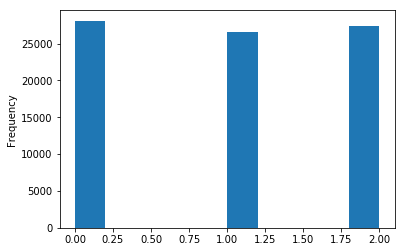

In [96]:
df["label"].plot(kind="hist")

## Groupping Data

In order to see how many data points belongs to eachy gps datapoint, we can group the data regarding to the `id_gps` and the `label` column.

In [97]:
agg_df = df.groupby(["label","measurementID","id_gps"]).max()
agg_df.reset_index()

label  measurementID  id_gps    time        lat        lon      height  \
0         0              0       2    2.74  47.695267  17.724532  120.897892   
1         0              0       3    3.74  47.695335  17.724412  103.454252   
2         0              0       4    4.74  47.695273  17.724272  114.860346   
3         0              0       5    5.74  47.695239  17.724124  116.224856   
4         0              0       6    6.74  47.695201  17.723964  116.564390   
...     ...            ...     ...     ...        ...        ...         ...   
1624      2              2     343  350.54  47.684783  17.679882  116.377854   
1625      2              2     344  351.54  47.684659  17.679803  116.202333   
1626      2              2     345  352.54  47.684604  17.679693  115.963805   
1627      2              2     346  353.54  47.684578  17.679542  115.755011   
1628      2              2     347  357.68  47.684570  17.679392  115.618638   

       velocity   direction  h_accuracy  v_accuracy  x_lin_acc  y_lin_acc  \
0     10.737622   -1.000000   48.000000   48.000000   0.236575   0.358446   
1     11.802929   -1.000000   32.000000   32.000000   0.197633   0.279384   
2     11.802929   -1.000000   32.000000   32.000000   0.490266   0.916718   
3     12.074264   -1.000000   16.000000   16.000000   0.159516   0.620798   
4     13.230871   -1.000000   24.000000   24.000000   0.197703   0.462520   
...         ...         ...         ...         ...        ...        ...   
1624  10.992300  192.645981    4.000604    4.000604   1.548266   0.499876   
1625  10.992300  222.072998    4.000604    4.000604   0.697311   0.778951   
1626  10.849288  236.163361    4.000604    4.000604   1.684225   1.407813   
1627  10.461895  256.485901    6.000906    6.000906   2.852724   0.376117   
1628  10.776369  270.572754    6.000906    6.000906   4.046536  -0.024874   

      z_lin_acc    x_gyro    y_gyro    z_gyro     x_acc     y_acc      z_acc  
0      0.391035  0.020479  0.015144  0.023898 -0.080907  1.917288  10.051223  
1      0.566038  0.033644  0.026803  0.025231 -0.156799  1.863026  10.140812  
2      0.458125  0.039789  0.012694  0.025446  0.216076  1.511931  10.138642  
3      0.769930  0.022122  0.016874 -0.004329  0.126936  1.334999  10.388697  
4      0.613292  0.026082  0.026888  0.012989  0.154554  1.396895  10.296863  
...         ...       ...       ...       ...       ...       ...        ...  
1624   2.097525  0.067881  0.075961  0.022605  1.758319 -0.255818  11.909459  
1625   0.788303  0.028065  0.032496 -0.001597  0.775088 -0.306188  10.920241  
1626   1.393465  0.069186  0.052650 -0.100964  2.676509  0.637674  11.189456  
1627   0.828247  0.037157  0.080711 -0.195026  4.200191 -0.019609  10.451865  
1628   2.252928  0.080960  0.167260 -0.041078  5.811440  0.678240  11.848087  

[1629 rows x 20 columns]

In [98]:
fig = px.scatter_mapbox(agg_df.reset_index(), 
                        lat="lat", 
                        lon="lon",
                        zoom = 12, 
                        height=500, 
                        color = "label", 
                        color_continuous_scale=["green","blue","red"])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.showscale = False
fig

### Representing the number of datapoints / gps data

We need to do some data transformation, to get the data in a form which can be plotted.

In [5]:
agg_df.reset_index(inplace=True)

In [6]:
agg_df = agg_df[["label","id_gps","time"]]

In [6]:
agg_df.columns = ["label","id_gps","count"]
agg_df.head()

label  id_gps  count
0      0       2     50
1      0       3     50
2      0       4     50
3      0       5     50
4      0       6     50

Text(0, 0.5, 'Frequenzy')

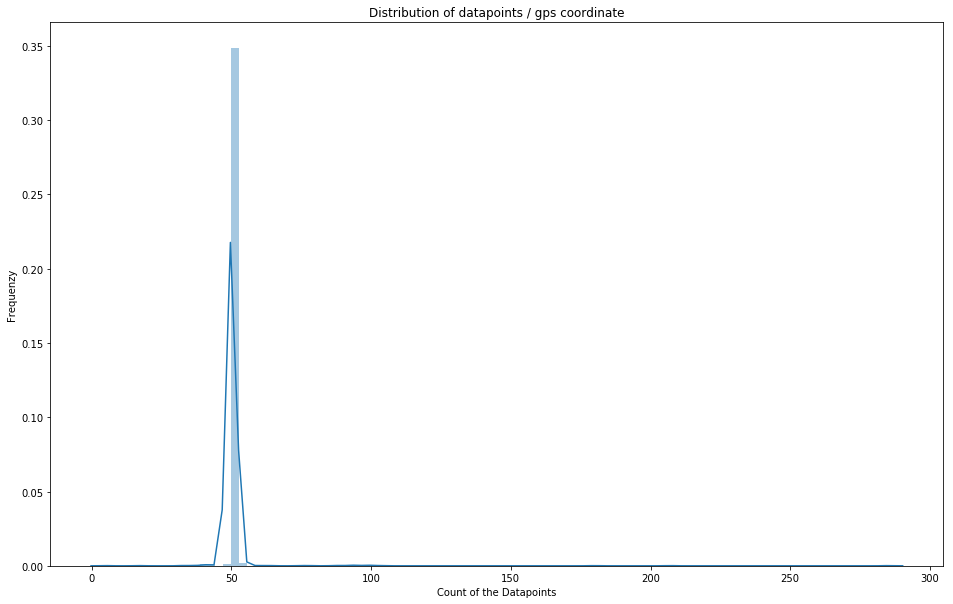

In [7]:
sns.distplot(agg_df["count"], 100)
plt.title("Distribution of datapoints / gps coordinate")
plt.xlabel("Count of the Datapoints")
plt.ylabel("Frequenzy")

The data point are equally distributed

### Prepare data

In [99]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', "z_lin_acc", 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["label", "measurementID", "id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})

    return agg_df

In [100]:
feature_df = create_aggregated(df).reset_index()

In [101]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Columns: 129 entries, ('label', '') to ('z_gyro', 'crest')
dtypes: float64(126), int64(3)
memory usage: 1.6 MB


In [102]:
feature_df.isna().sum().max()

0

## Shuffle Data

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
new_cols = []
for k,i in enumerate(feature_df.columns):
    if k >=3:
        new_cols.append(i[0] + "_" +  i[1])
    else:
        new_cols.append(i[0])

In [105]:
feature_df.columns = new_cols

In [106]:
print(feature_df[feature_df["label"] == 1]["measurementID"].unique())


[0 1]


In [107]:
X = feature_df.drop(["label"], axis=1)
y = feature_df["label"]

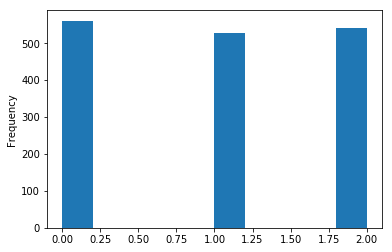

In [108]:
y.plot(kind = "hist")

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  shuffle = True)

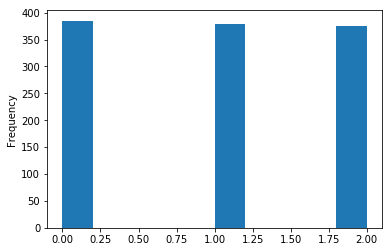

In [110]:
y_train.plot(kind = "hist")

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    shuffle =  True)

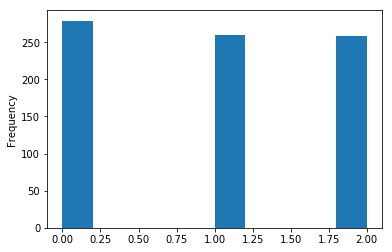

In [112]:
y_train.plot(kind =  "hist")

In [113]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (798, 128)
X_val:  (489, 128)
X_test:  (342, 128)
y_train:  (798,)
y_val:  (489,)
y_test:  (342,)


Checking the number of the labels in the train, validation and test datasets.

In [114]:
print("Number of label for each label in the train dataset: {}".format(Counter(y_train).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_val).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_test).most_common()))

Number of label for each label in the train dataset: [(0, 279), (1, 260), (2, 259)]
Number of label for each label in the validation dataset: [(0, 176), (2, 164), (1, 149)]
Number of label for each label in the validation dataset: [(1, 119), (2, 117), (0, 106)]


##  Prepare for ML

In [115]:
feature_df.columns

Index(['label', 'measurementID', 'id_gps', 'x_lin_acc_sum', 'x_lin_acc_mean',
       'x_lin_acc_mad', 'x_lin_acc_median', 'x_lin_acc_min', 'x_lin_acc_max',
       'x_lin_acc_std',
       ...
       'z_gyro_min', 'z_gyro_max', 'z_gyro_std', 'z_gyro_var', 'z_gyro_sem',
       'z_gyro_skew', 'z_gyro_quantile', 'z_gyro_kurtosis_time',
       'z_gyro_rms_100', 'z_gyro_crest'],
      dtype='object', length=129)

In [116]:
if not os.path.exists("../data/train_test_val"):
        os.makedirs("../data/train_test_val")

cols = feature_df.drop(["label"], axis=1).columns
        
pd.DataFrame(X_train, columns=cols).to_csv( "../data/train_test_val/X_train.csv")
pd.DataFrame(X_val, columns=cols).to_csv("../data/train_test_val/X_val.csv")
pd.DataFrame(X_test, columns=cols).to_csv("../data/train_test_val/X_test.csv")
        
pd.DataFrame(y_train).to_csv( "../data/train_test_val/y_train.csv")
pd.DataFrame(y_val).to_csv("../data/train_test_val/y_val.csv")
pd.DataFrame(y_test).to_csv("../data/train_test_val/y_test.csv")